# 十分钟强化学习第三讲：探索和利用

## 餐厅选择问题

知道MDP是理想情况，现实是只能通过和环境交互来了解信息

## 多臂老虎机 Multi-armed bandit 

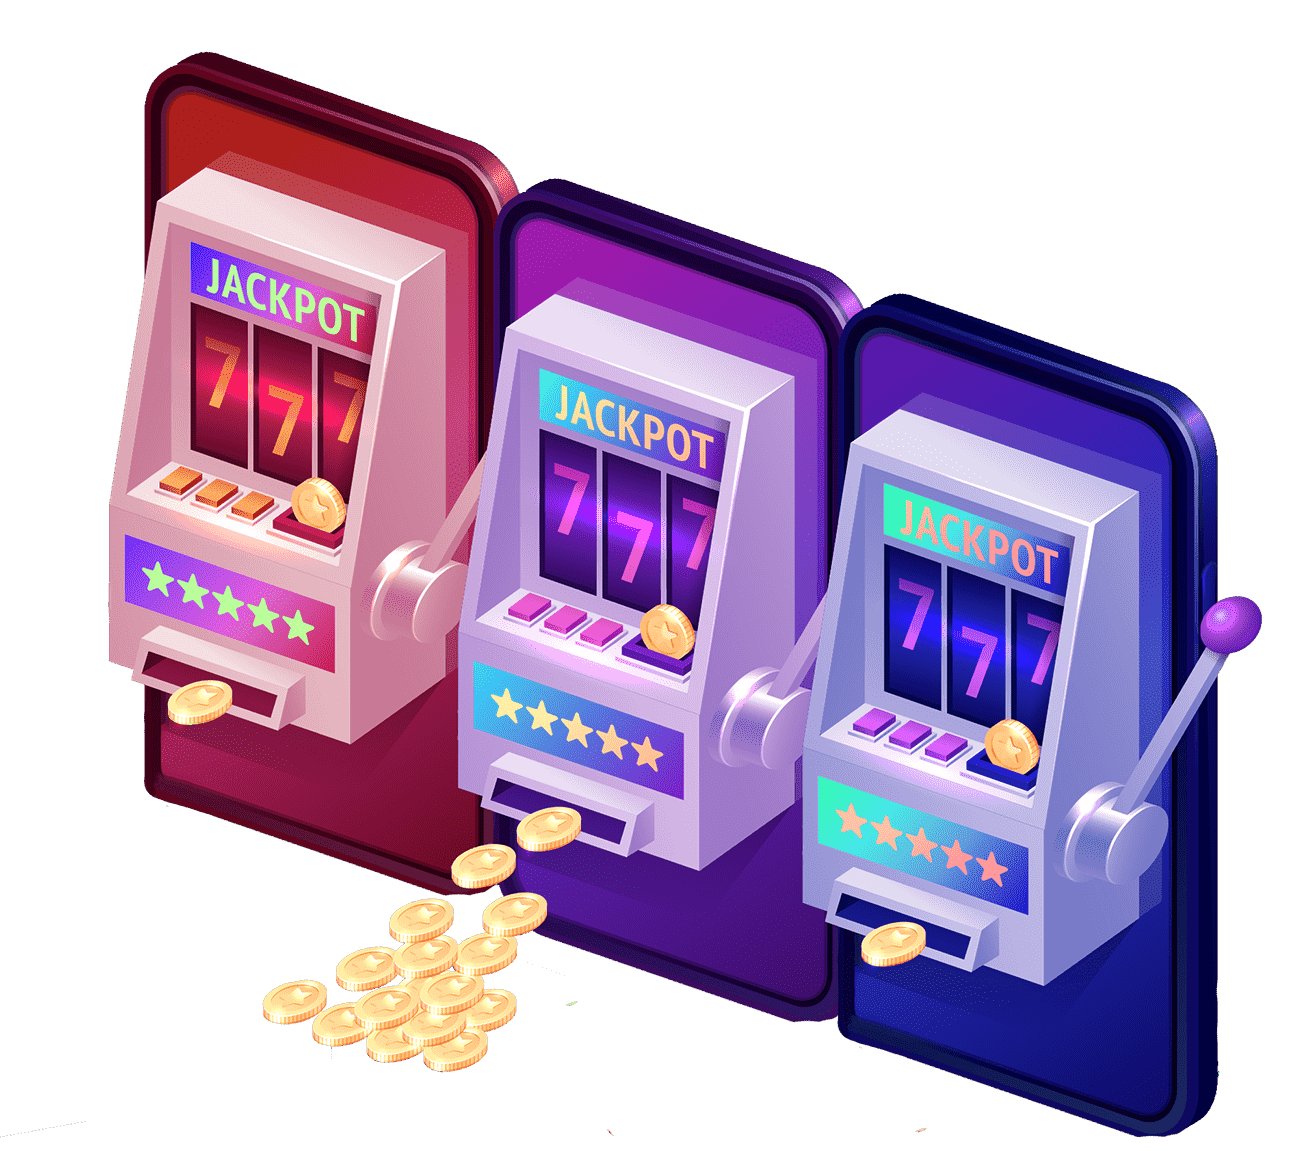

和冰湖问题不同，MAB问题只有单步决策，剥离了顺序决策的问题。只需要考虑如何平衡探索和利用。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 构建老虎机环境

In [4]:
class BanditEnv:

    def __init__(self, p_dist, r_dist):

        self.p_dist = p_dist
        self.r_dist = r_dist
        self.n_bandits = len(p_dist)

    def step(self, action):
        reward = 0
        done = True
        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done

    def reset(self):
        return 0

In [54]:
FourArmBanditEnv = BanditEnv(p_dist=[0.05, 0.1, 0.3, 0.2], r_dist=[1, 1, 1, 1])

## 纯探索的策略

In [59]:
def pure_exploration(env, n_episodes=1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)

    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    for e in range(n_episodes):
        action = np.random.randint(len(Q))
        _, reward, _, = env.step(action)
        N[action] += 1
        # moving average
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(n_episodes) + 1)
    return returns, Qe, actions, episode_mean_reward

In [60]:
returns, Qe, actions, mean_reward_pure_exp = pure_exploration(FourArmBanditEnv)

In [62]:
print(Qe)

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.04761905 0.07112971 0.31428571 0.19502075]
 [0.04761905 0.07112971 0.31707317 0.19502075]
 [0.04744526 0.07112971 0.31707317 0.19502075]]


虽然信息收集的很不错，但没有很好的利用这些信息。

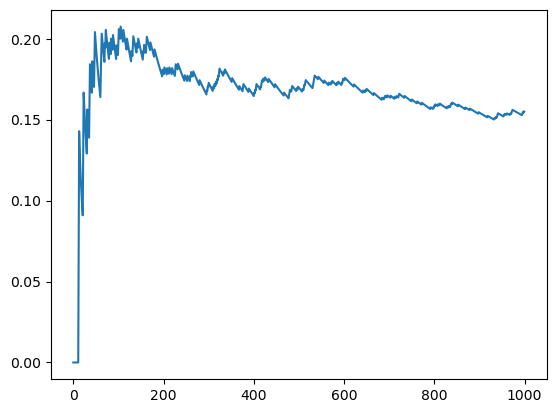

In [64]:
plt.plot(mean_reward_pure_exp)

## 纯利用策略

In [567]:
def pure_exploitation(env, n_episodes=1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)

    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    for e in range(n_episodes):
        action = np.argmax(Q)
        _, reward, _,  = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    return returns, Qe, actions, episode_mean_reward

In [568]:
_, Qe_pure_exploitation, _, mean_reward__pure_exploitation = pure_exploitation(FourArmBanditEnv)

In [569]:
print(Qe_pure_exploitation)

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.04609218 0.         0.         0.        ]
 [0.04704705 0.         0.         0.        ]
 [0.047      0.         0.         0.        ]]


过于急功近利，没有和环境交互以收集信息，也得不到好的回报

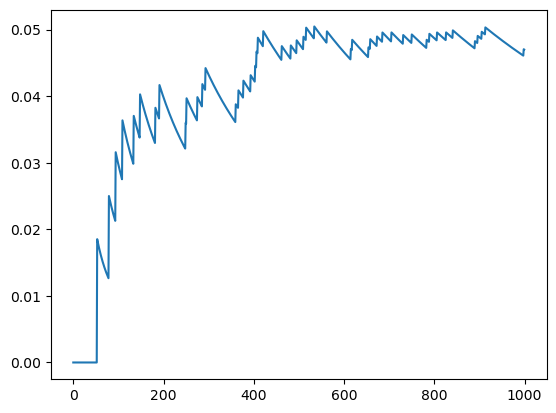

In [570]:
plt.plot(mean_reward__pure_exploitation)

## epsilon_greedy策略：一种探索和利用的平衡思路

- 部分时间去探索，部分时间去利用

In [72]:
def epsilon_greedy(env, epsilon=0.1, n_episodes=1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)

    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    for e in range(n_episodes):
        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    return returns, Qe, actions, episode_mean_reward

In [73]:
returns, Qe_epsilon, actions, mean_reward_epsilon = epsilon_greedy(FourArmBanditEnv)

In [74]:
print(Qe_epsilon)

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.02985075 0.03571429 0.30758808 0.2       ]
 [0.02985075 0.03571429 0.30717185 0.2       ]
 [0.02985075 0.03571429 0.30810811 0.2       ]]


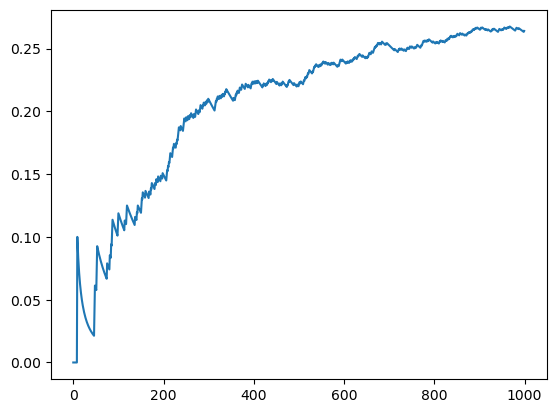

In [75]:
plt.plot(mean_reward_epsilon)

## 进阶版本的epsilon_greedy

- 早期的时候更多机会去探索，晚期地时候更多机会去利用

In [98]:
def lin_dec_epsilon_greedy(env,
                           init_epsilon=1.0,
                           min_epsilon=0.01, 
                           decay_ratio=0.01, 
                           n_episodes=1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)

    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    for e in range(n_episodes):
        decay_episodes = e * decay_ratio
        epsilon = init_epsilon -  decay_episodes
        epsilon = max(epsilon, min_epsilon)
        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    return returns, Qe, actions,episode_mean_reward

In [99]:
returns, Qe_dec_epsilon, actions, mean_reward_dec_epsilon = lin_dec_epsilon_greedy(FourArmBanditEnv)

In [100]:
print(Qe_dec_epsilon)

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.         0.125      0.30552291 0.15789474]
 [0.         0.125      0.30516432 0.15789474]
 [0.         0.125      0.30480657 0.15789474]]


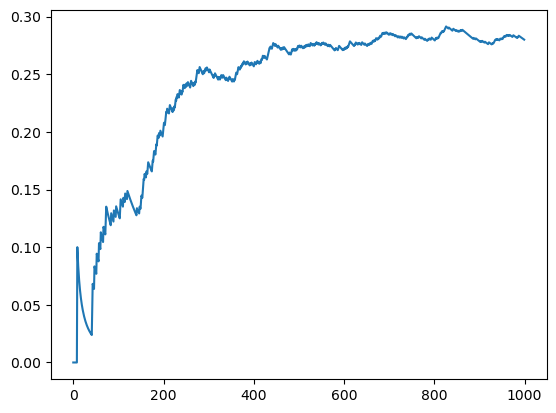

In [101]:
plt.plot(mean_reward_dec_epsilon)

## Softmax策略：

- 基于Q值来随机选择不同的action，高Q值的action被选中概率越来越大。

In [497]:
def softmax_strategy(env, 
            min_temp = 0.01,
            n_episodes = 1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)

    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    temp = np.logspace(0, -4, n_episodes)
    for e in range(n_episodes):
        temp_value = max(temp[e], min_temp)
        scaled_Q = Q / temp_value
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)

        action = np.random.choice(np.arange(len(probs)), 
                                  size=1, 
                                  p=probs)[0]

        _, reward, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    return returns, Qe, actions,episode_mean_reward

In [509]:
_, Qe_softmax, _, mean_reward_softmax = softmax_strategy(FourArmBanditEnv)

In [510]:
Qe_softmax

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.0625    , 0.1       , 0.31736527, 0.22666667],
       [0.0625    , 0.1       , 0.31818182, 0.22666667],
       [0.0625    , 0.1       , 0.31899642, 0.22666667]])

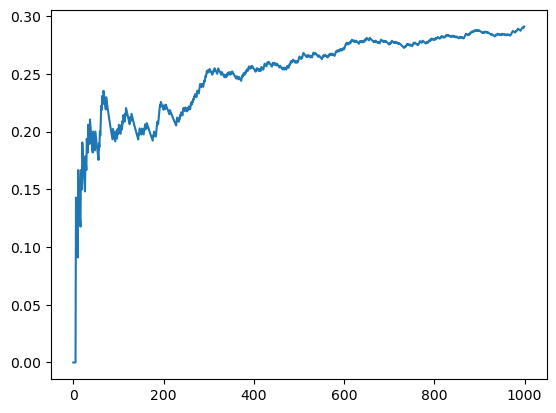

In [511]:
plt.plot(mean_reward_softmax)

## UCB策略

- 基于Q值和未探索的程度，来选择最优的action

In [561]:
def upper_confidence_bound(env, 
                           c=0.5, 
                           n_episodes=1000):
    Q = np.zeros((env.n_bandits), dtype=np.float64)
    N = np.zeros((env.n_bandits), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.n_bandits), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    for e in range(n_episodes):
        action = e
        if e >= len(Q):
            U = c * np.sqrt(np.log(e)/N)
            action = np.argmax(Q + U)

        _, reward, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    episode_mean_reward = np.cumsum(returns) / (np.arange(len(returns)) + 1)
    return returns, Qe, actions,episode_mean_reward

In [564]:
_, Qe_UCB, _, mean_reward_UCB = upper_confidence_bound(FourArmBanditEnv)

In [565]:
print(Qe_UCB)

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 ...
 [0.10344828 0.05263158 0.3105802  0.1971831 ]
 [0.10344828 0.05263158 0.31022727 0.1971831 ]
 [0.10344828 0.05263158 0.30987514 0.1971831 ]]


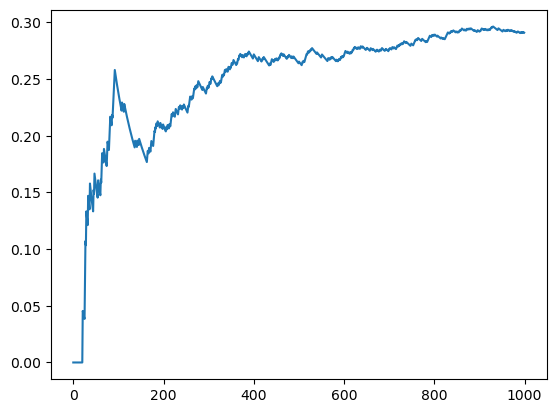

In [566]:
plt.plot(mean_reward_UCB)